# Portland Trail Blazers - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 5 # blazers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(27485, 54)

### We should specify the features used in our model:

In [4]:
# choose the features for the stellar base retention model
features = [
    "annualHHIncome",
    "attendancePercent",
    "cancel_records",
    "childrenPresentInHH", 
    "clickToOpenRatio", 
    "clickToSendRatio",
    "dimCustomerMasterId",
    "distToVenue",
    "education",
    "fill_out_form",
    "forward_records",
    "gender",
    "isNextYear_Buyer",
    "lengthOfResidenceInYrs",
    "maritalStatus",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "posting_records",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "resale_atp",
    "resale_records",
    "source_tenure",
    "tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (18595, 29)
Unseen Data For Predictions: (3281, 29)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "annualHHIncome",
        "attendancePercent",
        "cancel_records",
        "childrenPresentInHH", 
        "clickToOpenRatio", 
        "clickToSendRatio",
        "distToVenue",
        "fill_out_form",
        "forward_records",
        "lengthOfResidenceInYrs",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "openToSendRatio",
        "posting_records",
        "recency",
        "renewedBeforeDays",
        "resale_atp",
        "resale_records",
        "source_tenure",
        "tenure",
        "totalSpent"
    ]
);

In [6]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7501,0.8610,0.7013,0.8818,0.7811,0.4988,0.5168,1.3150


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost

### Let's load in our 2021 season data and get retention scores using the model:

In [7]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5609, 29)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions = new_predictions[new_predictions["Score_1"] >= 0.025]

new_predictions.head()

,annualHHIncome,attendancePercent,cancel_records,childrenPresentInHH,clickToOpenRatio,clickToSendRatio,dimCustomerMasterId,distToVenue,education,fill_out_form,...,renewedBeforeDays,resale_atp,resale_records,source_tenure,tenure,totalSpent,year,Label,Score_0,Score_1
21876,0,0.812500,0,1,0.128788,0.104938,779,0,0,4,...,270,0.0,0,16060,1876,2323.20,2021,1,0.1540,0.8460
21877,0,1.046512,0,1,0.067039,0.035661,1350,0,0,0,...,270,0.0,0,2920,1125,11835.00,2021,1,0.1380,0.8620
21878,0,0.687500,0,1,0.548387,0.240793,1358,0,0,0,...,269,0.0,0,16425,1889,1580.00,2021,0,0.5281,0.4719
21879,0,0.730159,0,1,0.664756,0.320885,3727,0,0,12,...,269,0.0,0,2920,1889,4841.37,2021,1,0.2436,0.7564
21880,0,0.954545,0,1,0.000000,0.000000,4051,0,0,0,...,53,0.0,0,1825,767,36000.00,2021,0,0.3336,0.6664


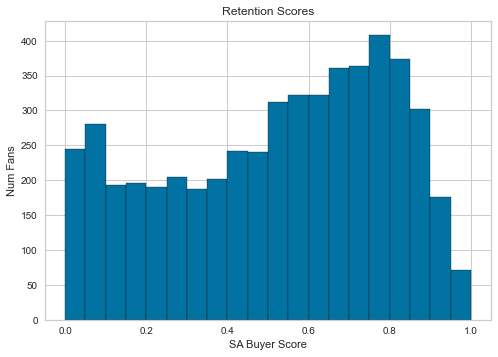

In [11]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(new_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

In [13]:
new_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]        71
(0.9, 0.95]       176
(0.85, 0.9]       302
(0.8, 0.85]       373
(0.75, 0.8]       408
(0.7, 0.75]       363
(0.65, 0.7]       362
(0.6, 0.65]       322
(0.55, 0.6]       322
(0.5, 0.55]       311
(0.45, 0.5]       242
(0.4, 0.45]       242
(0.35, 0.4]       202
(0.3, 0.35]       188
(0.25, 0.3]       204
(0.2, 0.25]       190
(0.15, 0.2]       196
(0.1, 0.15]       193
(0.05, 0.1]       280
(-0.001, 0.05]    245
Name: Score_1, dtype: int64

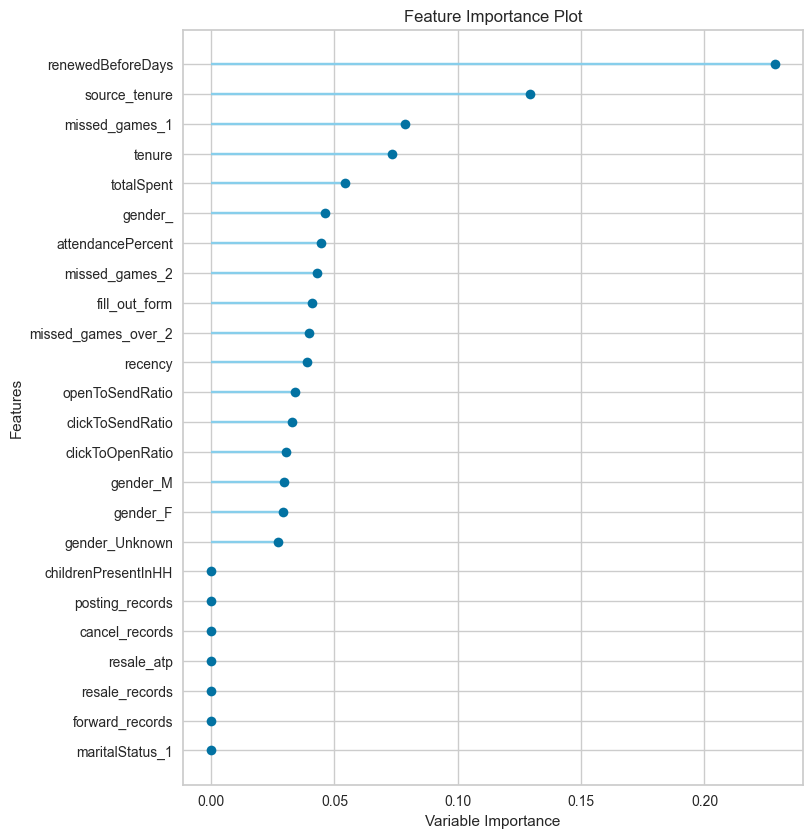

In [15]:
plot_model(final_model, plot='feature_all')

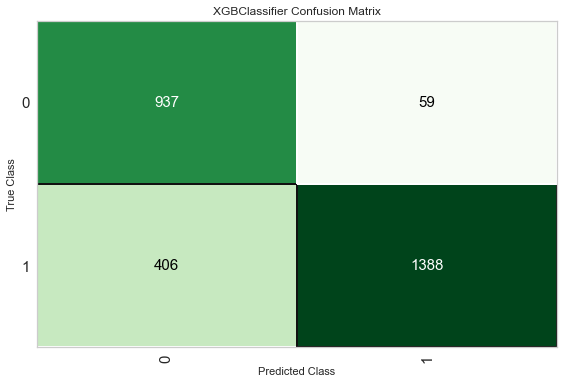

In [16]:
plot_model(final_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?